In [1]:
%load_ext tensorboard

In [2]:
!rm -rf ./logs/ 

In [3]:
from __future__ import absolute_import, division, print_function

import datetime
import functools
import time
import numpy as np
import scipy as sp
from scipy.fftpack import diff as psdiff

from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.utils import conv_utils
from pprint import pprint

In [4]:
version = tf.__version__
executing_eagerly = tf.executing_eagerly()
gpu_available = tf.config.list_physical_devices()
print('Tensorflow version: {}\n'
      'Executing eagerly: {}\n'
      'GPU available: {}'
      .format(version, 
              executing_eagerly, 
              gpu_available))

Tensorflow version: 2.3.0
Executing eagerly: True
GPU available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


# Loading Data

In [5]:
nx,ny = 50,50
dx,dy = 2*np.pi/nx, 2*np.pi/ny
t=.2
time_step=.01
num_timesteps = int(np.floor(t/time_step))

xx, yy = np.meshgrid(np.linspace(0, 2*np.pi, nx), np.linspace(0, 2*np.pi, ny))
a = .5 * (np.cos(yy) + xx*(2*np.pi - xx) * np.sin(xx)) + .6
b = 2 * (np.cos(yy) + np.sin(xx)) + .8
c = .2 * np.ones((nx,ny))
d = .3 * np.ones((nx,ny))

equation_dict = {
    (0,0): np.zeros((nx,ny)),
    (1,0): a,
    (0,1): b,
    (2,0): c,
    (0,2): d,
    (1,1): np.zeros((nx,ny))
}

In [6]:
def visualize_dict(equation_dict, order=2):
    fig = plt.figure(figsize=(10,8))

    for i in range(order+1):
        for j in range(order+1):
            if(i+j<=order):
                ax = plt.subplot2grid((5,5), (2*i,2*j))
                ax.axis('off')
                ax.imshow(equation_dict[(i,j)].reshape(nx,ny), 
                          norm=plt.Normalize(-4,4), cmap='viridis')
                ax.title.set_text("c_{}{}".format(i,j))
    fig.show()

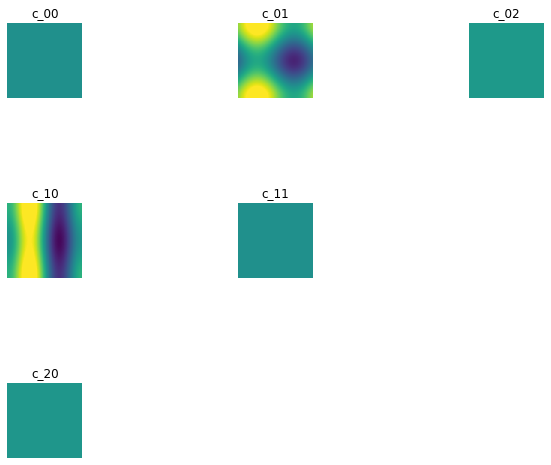

In [7]:
visualize_dict(equation_dict)

In [8]:
def _deserialize_example(example_proto, nx, ny, steps):
    feature_description = {
        'initial_condition': tf.io.FixedLenFeature([nx*ny], tf.float32),
        'label': tf.io.FixedLenFeature([steps*nx*ny], tf.float32)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    x = tf.reshape(example['initial_condition'], tf.stack([nx,ny]))
    y = tf.reshape(example['label'], tf.stack([steps,nx,ny]))
    return x, y

def deserialize_example(nx,ny,steps):
    return lambda example_proto: _deserialize_example(example_proto, nx, ny, steps)

filenames = ['data/diffusion_data/train{}.tfrecord'.format(i) for i in range(20)]
raw_dataset = tf.data.TFRecordDataset(filenames)

parsed_dataset = raw_dataset.map(deserialize_example(nx,ny,int(t/time_step)))

In [9]:
for x,y in parsed_dataset.take(1):
    pass

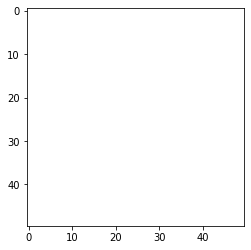

In [10]:
fig = plt.figure()
ims = [[plt.imshow(datum, animated=True)] for datum in y]
ani = animation.ArtistAnimation(fig, ims)
HTML(ani.to_jshtml())

# Equation Block

In [11]:
d_x = np.array([-1,1]).reshape(2,1,1,1).astype(np.float32)
d_y = np.array([-1,1]).reshape(1,2,1,1).astype(np.float32)

def gradient_l2(param, filter_size):
    def _gradient_l2(weight_matrix):
        W = K.transpose(K.reshape(weight_matrix, (1,nx,ny,filter_size)))
        W_x = K.conv2d(W,d_x)
        W_y = K.conv2d(W,d_y)
        return param * K.sum([K.sum(K.square(W)),
                              K.sum(K.square(W_x)),
                              K.sum(K.square(W_y))])
        
    return _gradient_l2

In [12]:
def fully_frozen_filters(n):            
    M = np.array([1/(np.math.factorial(i) * np.math.factorial(j))
                   *np.array([k_1**(i)*k_2**(j) 
                              for k_1 in range(-1*(n-1)//2, (n-1)//2 + 1) 
                              for k_2 in range(-1*(n-1)//2, (n-1)//2 + 1)])
                   for i in range(n) 
                  for j in range(n)]).T
    return sp.linalg.solve(M, np.identity(n**2))

In [13]:
class SumRule(tf.keras.constraints.Constraint):
       
    def __init__(self, sum_rule):
        assert sum_rule.shape[0] == sum_rule.shape[1]
        self.n = sum_rule.shape[0]
        self.rule = sum_rule.flatten()
        self.frozen_filters = tf.constant(fully_frozen_filters(self.n).astype(np.float32))
        self.k = tf.constant(self._k(self.n).astype(np.float32))
        
    def _k(self,n):
        return np.array([1/(np.math.factorial(i) * np.math.factorial(j))
                          *np.array([k_1**(i)*k_2**(j) 
                                     for k_1 in range(-1*(n-1)//2, (n-1)//2 + 1) 
                                     for k_2 in range(-1*(n-1)//2, (n-1)//2 + 1)])
                          for i in range(n)
                          for j in range(n)])
        
    def __call__(self, w):
        w = tf.reshape(w, (self.n**2,1))
        updates = K.dot(tf.gather(self.k, np.where(self.rule == 0)[0]), w)
        orth = tf.gather(self.frozen_filters, np.where(self.rule == 0)[0])
        w = w - K.dot(K.transpose(orth), updates)
        norm = K.dot(tf.gather(self.k, np.where(self.rule == 1)[0]), w)
        relevant_filter = tf.gather(self.frozen_filters, np.where(self.rule == 1)[0])
        #w = w + (1 - norm) * K.transpose(relevant_filter)
        #w = w / (norm + K.sign(norm) * K.epsilon())
        return tf.reshape(w, (self.n,self.n,1,1))

In [14]:
class UnfrozenDerivative:
    
    def __init__(self, sum_rule, n):
        self.sum_rule = sum_rule
        self.k = self._k(n)
        self.inv_k = sp.linalg.inv(self.k)
    
    def _k(self, n):
        return np.array([1/(np.math.factorial(i) * np.math.factorial(j))
                          *np.array([k_1**(i)*k_2**(j) 
                                     for k_1 in range(-1*(n-1)//2, (n-1)//2 + 1) 
                                     for k_2 in range(-1*(n-1)//2, (n-1)//2 + 1)])
                          for i in range(n)
                          for j in range(n)])
    
    def build(self, input_shape):
        pass
        
    def __call__(self, inputs):
        inputs = K.dot(self.inv_k, inputs)
        outputs = K.conv2d(inputs, self.w)
        outputs = K.dot(self.k, outputs)
        return outputs
        

In [15]:
def fully_unfrozen_rules(n):
    unfrozen_rules = np.identity(n**2).reshape(n,n,n,n)
    for k in range(n):
        for l in range(n):
            for i in range(n):
                for j in range(n):
                    if i+j > k+l:
                        unfrozen_rules[k,l,i,j] = None
    return unfrozen_rules

In [16]:
class NonPos(tf.keras.constraints.Constraint):
    """Constrains the weights incident to each hidden unit to Negative.
    """

    def __init__(self):
        pass

    def __call__(self, w):
        w = w * K.cast(K.less_equal(w, 0.), K.floatx())
        return w

In [17]:
def wrap_padding(x, padding=1):
    for i, p in enumerate(padding):
        if p[0] > 0 and p[1] > 0:
            x = tf.concat([tf.gather(x, list(range(x.shape[i] - p[0], x.shape[i])), axis=i), 
                          x, 
                          tf.gather(x, list(range(p[1])), axis=i)], axis=i)
        elif p[0] > 0:
            x = tf.concat([tf.gather(x, list(range(x.shape[i] - p[0], x.shape[i])), axis=i), 
                          x], axis=i)
        elif p[1] > 0:
            x = tf.concat([x, 
                          tf.gather(x, list(range(p[1])), axis=i)], axis=i)
        else:
            pass
        
    return x

WrapPadding = lambda padding: tf.keras.layers.Lambda(lambda x: wrap_padding(x, padding))

In [18]:
class DeltaT(tf.keras.layers.Layer):
    
    def __init__(self, 
                 nx, 
                 ny,
                 filter_size,
                 wavelet_size=3,
                 order=2,
                 sum_rules=None,
                 strides=(1,1),
                 padding='valid',
                 data_format='channels_last',
                 dilation_rate=(1,1),
                 functional_initializer='glorot_uniform',
                 functional_constant_initializers=None,
                 functional_regularizer=None,
                 activation=None,
                 activity_regularizer=None,
                 trainable=True,
                 **kwargs):
        
        super(DeltaT, self).__init__(**kwargs)
        self.nx = nx
        self.ny = ny
        self.filter_size = filter_size
        self.wavelet_size = wavelet_size
        n = self.wavelet_size
        self.frozen_filters = fully_frozen_filters(n).reshape(n,n,n**2)
        
        self.state_size = [nx*ny*filter_size]
        self.order = order
        
        self.strides = strides
        self.padding = padding
        self.data_format = data_format
        self.dilation_rate = dilation_rate
        
        self.functional_initializer = functional_initializer
        self.functional_regularizer = functional_regularizer
        self.activation = activation
        self.activity_regularizer = activity_regularizer
        self.trainable = trainable
        self.equation_block = {}
        
        if sum_rules is None:
            self.sum_rules = np.identity(n**2).reshape(n,n,n,n).astype(np.float32)
        else:
            self.sum_rules = sum_rules
        
        if self.functional_initializer == 'constant':
            self.functional_constant_initializers = functional_constant_initializers

        
        
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        
        input_dim = input_shape[channel_axis]
        self.kernel_size = (self.wavelet_size, self.wavelet_size, 1, self.filter_size)
        assert self.order == 2
        for i in range(3):
            for j in range(3):
                if i+j > 2:
                    continue
                modified_wavelet = np.repeat(self.frozen_filters[i,j]
                                                 .reshape(self.kernel_size[:3] + (1,)), 
                                             self.filter_size, 
                                             axis=-1).astype(np.float32)
                
                if self.functional_initializer == 'constant':
                    self.equation_block[(i,j)] = {
                        'D': self.add_weight(shape=self.kernel_size,
                                             initializer=tf.keras.initializers.Constant(modified_wavelet),
                                             name='D_{}{}'.format(i, j),
                                             trainable=self.trainable,
                                             constraint=SumRule(self.sum_rules[i,j])),
                        'c': self.add_weight(shape=(1, nx, ny, self.filter_size),
                                             initializer=tf.keras.initializers.Constant(self.functional_constant_initializers[i,j]),
                                             name='c_{}{}'.format(i, j),
                                             regularizer=self.functional_regularizer,
                                             trainable=self.trainable)
                    }
                else:
                    self.equation_block[(i,j)] = {
                        'D': self.add_weight(shape=self.kernel_size,
                                             initializer=tf.keras.initializers.Constant(modified_wavelet),
                                             name='D_{}{}'.format(i, j),
                                             trainable=False,
                                             #constraint=SumRule(self.sum_rules[i,j]))
                                            ),
                        'c': self.add_weight(shape=(1, nx, ny, self.filter_size),
                                             initializer=self.functional_initializer,
                                             name='c_{}{}'.format(i, j),
                                             regularizer=self.functional_regularizer,
                                             trainable=self.trainable)
                    }
        n = self.wavelet_size
        self.wrap_padding = WrapPadding(((0,0), ((n-1)//2,(n-1)//2), ((n-1)//2,(n-1)//2), (0,0)))
        self.reshape = tf.keras.layers.Reshape((nx, ny, self.filter_size))
        self.flatten = tf.keras.layers.Flatten()
        
        self.built = True
        
    def _call_block(self, padded_inputs, pair):
        outputs = K.conv2d(
            padded_inputs,
            self.equation_block[pair]['D'],
            strides=self.strides[0],
            data_format=self.data_format,
            dilation_rate=self.dilation_rate[0]
        )
        norm=dx**pair[1] * dy**pair[0]
        outputs = outputs/norm 
        outputs = self.equation_block[pair]['c'] * outputs
        return outputs
    
    def _identity(self, padded_inputs):
        outputs = K.conv2d(
            padded_inputs,
            self.equation_block[(0,0)]['D'],
            strides=self.strides[0],
            data_format=self.data_format,
            dilation_rate=self.dilation_rate[0]
        )
        return outputs
        
    def call(self, inputs, state):
        reshaped_inputs = self.reshape(state[0])
        padded_inputs = self.wrap_padding(reshaped_inputs)
        outputs = K.sum([self._call_block(padded_inputs, pair) for pair in self.equation_block.keys()], axis=0)
        outputs = reshaped_inputs + time_step * outputs
        #outputs = self._identity(padded_inputs) + time_step * outputs
        if self.activation is not None:
            return self.activation(outputs)
        
        return outputs, [self.flatten(outputs)]
    
    def visualize(self, norm=4, index=0):
        fig = plt.figure(figsize=(10,8))
        for i in range(self.order+1):
            for j in range(self.order+1):
                if(i+j<=self.order):
                    ax = plt.subplot2grid((5,5), (2*i,2*j))
                    ax.axis('off')
                    ax.imshow(self.equation_block[(i,j)]['c'][:,:,:,index]
                                  .numpy().reshape(nx,ny), 
                              norm=plt.Normalize(-norm, norm), cmap='viridis')
                    ax.title.set_text("c_{}{}".format(i,j))
        fig.show()

In [19]:
batch_size = 32
filter_size = 1
delta_t = DeltaT(nx, ny, filter_size,
                 functional_initializer='constant',
                 functional_constant_initializers=equation_dict,
                 trainable=False,
                 wavelet_size=5)
partial = tf.keras.layers.RNN(delta_t, return_sequences=True)

In [20]:
reshape = tf.keras.layers.Reshape((nx*ny,))
repeat = tf.keras.layers.RepeatVector(filter_size)
permute = tf.keras.layers.Permute([2,1])
reshape2 = tf.keras.layers.Reshape((nx,ny,filter_size))
flatten = tf.keras.layers.Flatten()

In [21]:
t0 = time.time()
for x,y in parsed_dataset.batch(batch_size).take(1):
    pass
o_e = flatten(permute(repeat(reshape(x))))
boop = partial(tf.zeros((batch_size,int(t/time_step),nx,ny,filter_size)), [o_e])
print(time.time() - t0)

0.745610237121582


# PDE Model

In [22]:
class PDENet(tf.keras.Model):
    
    def __init__(self, nx, ny, num_timesteps, filter_size, wavelet_size, batch_size=32, cheating=False):
        super(PDENet, self).__init__(name='pde_net')
        self.filter_size = filter_size
        self.num_timesteps = num_timesteps
        self.flatten = tf.keras.layers.Flatten()
        self.repeat = tf.keras.layers.RepeatVector(filter_size)
        self.permute = tf.keras.layers.Permute([2,1])
        self.wavelet_size = wavelet_size
        self.batch_size = batch_size
        if cheating:
            self.delta_t = DeltaT(nx, ny, filter_size,
                                  wavelet_size=self.wavelet_size,
                                  functional_initializer='constant',
                                  functional_constant_initializers=equation_dict,
                                  trainable=False)
        else:
            self.delta_t = DeltaT(nx, ny, filter_size,
                                  wavelet_size=self.wavelet_size,
                                  #sum_rules=fully_unfrozen_rules(self.wavelet_size),
                                  functional_regularizer= gradient_l2(.0001, self.filter_size))
        self.equation_layer = tf.keras.layers.RNN(self.delta_t, return_sequences=True)
        self.dense = tf.keras.layers.Dense(1, use_bias=False, 
                                           kernel_constraint=tf.keras.constraints.NonNeg())
        
    def call(self, input_tensor, training=False):
        x = self.flatten(input_tensor)
        x = self.repeat(x)
        x = self.permute(x)
        x = self.flatten(x)
        x = self.equation_layer(tf.zeros((self.batch_size,self.num_timesteps, nx, ny, self.filter_size)), x)
        #x = self.dense(x)
        return x

In [33]:
filter_size=1
wavelet_size=3
batch_size=64
epochs=200

In [34]:
model = PDENet(nx,ny, num_timesteps, filter_size, wavelet_size, batch_size=batch_size)

In [35]:
optim = tf.keras.optimizers.Adam(clipnorm=.05)

In [36]:
model.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
              metrics=[tf.keras.metrics.mean_squared_error])

In [37]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [38]:
model.fit(parsed_dataset.batch(batch_size).repeat(epochs), 
          epochs=epochs, 
          steps_per_epoch=100)

Epoch 1/200
100/100 [==============================] - 52s 518ms/step - loss: 132.7107 - mean_squared_error: 132.7006
Epoch 2/200
100/100 [==============================] - 51s 514ms/step - loss: 84.6806 - mean_squared_error: 84.6437
Epoch 3/200
100/100 [==============================] - 51s 511ms/step - loss: 61.5029 - mean_squared_error: 61.4168
Epoch 4/200
100/100 [==============================] - 51s 514ms/step - loss: 49.2031 - mean_squared_error: 49.0534
Epoch 5/200
100/100 [==============================] - 52s 516ms/step - loss: 42.9587 - mean_squared_error: 42.7429
Epoch 6/200
100/100 [==============================] - 52s 516ms/step - loss: 40.2145 - mean_squared_error: 39.9588
Epoch 7/200
100/100 [==============================] - 53s 528ms/step - loss: 39.0791 - mean_squared_error: 38.8013
Epoch 8/200
100/100 [==============================] - 52s 522ms/step - loss: 38.0261 - mean_squared_error: 37.7315
Epoch 9/200
100/100 [==============================] - 51s 514ms/step 

100/100 [==============================] - 50s 503ms/step - loss: 13.8948 - mean_squared_error: 12.2768
Epoch 72/200
100/100 [==============================] - 51s 508ms/step - loss: 13.7257 - mean_squared_error: 12.0954
Epoch 73/200
100/100 [==============================] - 52s 516ms/step - loss: 13.6809 - mean_squared_error: 12.0389
Epoch 74/200
100/100 [==============================] - 51s 508ms/step - loss: 13.5844 - mean_squared_error: 11.9324
Epoch 75/200
100/100 [==============================] - 51s 506ms/step - loss: 13.5240 - mean_squared_error: 11.8617
Epoch 76/200
100/100 [==============================] - 51s 506ms/step - loss: 13.3761 - mean_squared_error: 11.7041
Epoch 77/200
100/100 [==============================] - 51s 506ms/step - loss: 13.3263 - mean_squared_error: 11.6446
Epoch 78/200
100/100 [==============================] - 50s 504ms/step - loss: 13.2303 - mean_squared_error: 11.5399
Epoch 79/200
100/100 [==============================] - 51s 512ms/step - loss

KeyboardInterrupt: 

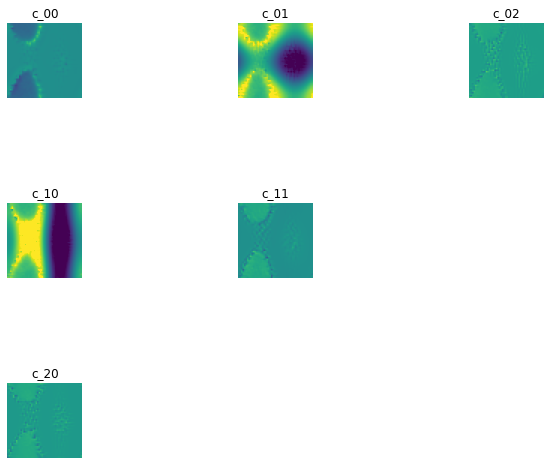

In [41]:
model.equation_layer.cell.visualize(norm=2.5)

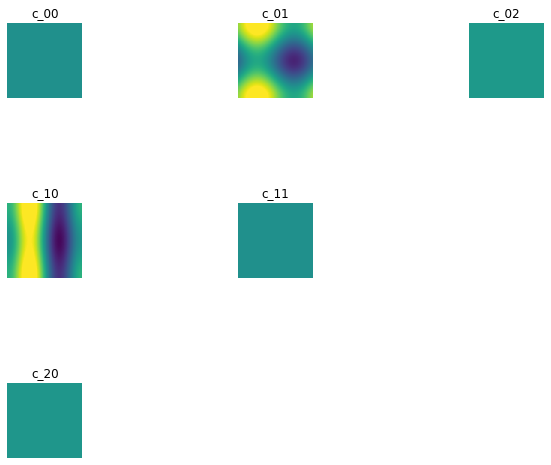

In [42]:
visualize_dict(equation_dict)

In [43]:
for x,y in parsed_dataset.take(1):
    pass

In [44]:
an = model.predict(np.array([x])).reshape(20,50,50)

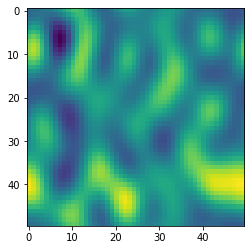

In [45]:
plt.imshow(x)

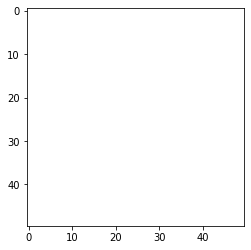

In [46]:
fig = plt.figure()
ims = [[plt.imshow(datum, animated=True)] for datum in y]
ani = animation.ArtistAnimation(fig, ims)
HTML(ani.to_jshtml())

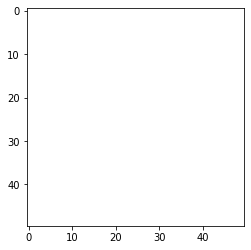

In [47]:
fig = plt.figure()
ims = [[plt.imshow(datum, animated=True)] for datum in an]
ani = animation.ArtistAnimation(fig, ims)
HTML(ani.to_jshtml())